# Trabalho de Classificação: Banknote Authentication

**Alunos:** Tales Araujo Kodama e Thiago Rovari

**Disciplina:** Inteligência Artificial - ECOM08A

### Introdução e Escolha do Dataset
O objetivo deste trabalho é comparar o desempenho de quatro algoritmos de classificação (Regressão Logística, Árvore de Decisão, SVM e MLP) em um problema de classificação binária.

**Dataset Escolhido:** Banknote Authentication Data Set (UCI/Kaggle).
* **Objetivo:** Classificar se uma cédula bancária é **Autêntica (0)** ou **Falsa (1)**.
* **Features (Entrada):** 4 variáveis contínuas extraídas de imagens das notas (Variância, Assimetria, Curtose, Entropia).
* **Target (Saída):** A classe da nota (0 ou 1).

Este dataset foi escolhido por apresentar um problema de classificação claro, mas com fronteiras de decisão não-lineares, ideal para testar a capacidade de generalização de modelos mais complexos como SVM e Redes Neurais.

O dataset escolhido foi o 'BMW Worldwide Sales Records 2010-2024'. O objetivo deste notebook é construir um modelo de classificação capaz de prever a coluna Sales_Classification (que indica vendas 'High' ou 'Low') com base em outras características do carro, como Região, Cor, Tipo de Combustível, etc. A df.info() mostra que temos várias colunas de texto (object) que precisarão ser convertidas."

### **1. Carregar os Dados**

In [73]:
import pandas as pd

df = pd.read_csv('BankNoteAuthentication.csv')

print("----- Primeiras 5 linhas -----")
print(df.head())
print("\n ----- Informações das Colunas ----- ")
print(df.info())

----- Primeiras 5 linhas -----
   variance  skewness  curtosis  entropy  class
0   3.62160    8.6661   -2.8073 -0.44699      0
1   4.54590    8.1674   -2.4586 -1.46210      0
2   3.86600   -2.6383    1.9242  0.10645      0
3   3.45660    9.5228   -4.0112 -3.59440      0
4   0.32924   -4.4552    4.5718 -0.98880      0

 ----- Informações das Colunas ----- 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB
None


### **2. Análise Exploratória dos Dados (EDA)**

Antes de iniciar o treinamento, é fundamental entender a distribuição das classes para verificar se o dataset está balanceado.

O gráfico abaixo mostra a contagem de amostras para cada classe:

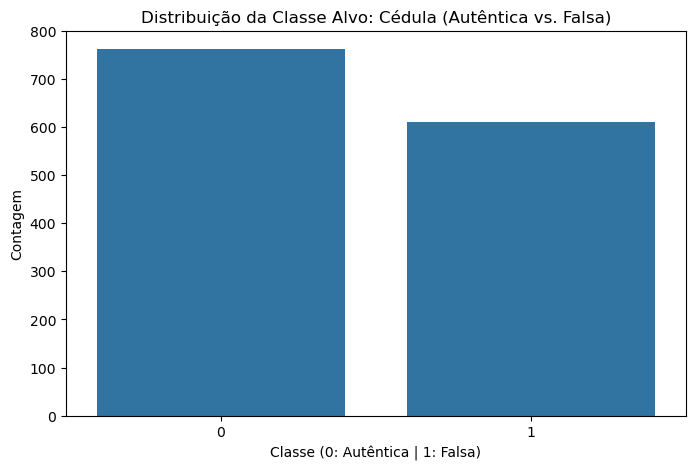

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=df)
plt.title('Distribuição da Classe Alvo: Cédula (Autêntica vs. Falsa)')
plt.xlabel('Classe (0: Autêntica | 1: Falsa)') 
plt.ylabel('Contagem')
plt.show()

Para compreender a complexidade da fronteira de decisão, plotamos as três principais features (variance, skewness, curtosis) em um espaço tridimensional como visto no gráfico abaixo.

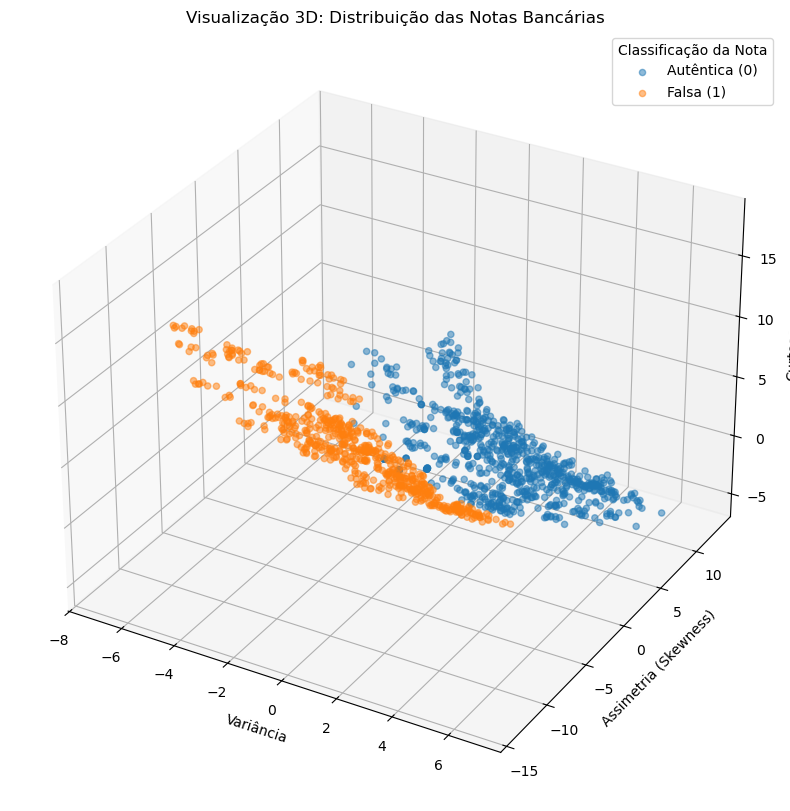

In [200]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(df[df['class'] == 0]['variance'], df[df['class'] == 0]['skewness'], df[df['class'] == 0]['curtosis'], alpha=.5, label='Autêntica (0)')

ax.scatter(df[df['class'] == 1]['variance'], df[df['class'] == 1]['skewness'], df[df['class'] == 1]['curtosis'], alpha=.5, label='Falsa (1)')

plt.legend(title="Classificação da Nota")
ax.set_xlabel('Variância')
ax.set_ylabel('Assimetria (Skewness)')
ax.set_zlabel('Curtose')
plt.title('Visualização 3D: Distribuição das Notas Bancárias')

plt.show()

### **3. Pré-processamento e Divisão dos Dados**

Para garantir o melhor desempenho dos modelos, realizamos as seguintes etapas:

1.  **Seleção de Features:** Utilizaremos 3 features principais (`variance`, `skewness`, `curtosis`) para permitir a visualização tridimensional dos dados.
2.  **Padronização (Scaling):** Aplicamos o `StandardScaler` para normalizar as features (média 0 e desvio padrão 1). Isso é **obrigatório** para o bom funcionamento do SVM e da Rede Neural (MLP), que são sensíveis à escala dos dados.

In [88]:
from sklearn.preprocessing import StandardScaler

y = df['class']

X= df[['variance', 'skewness', 'curtosis']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_final = pd.DataFrame(X_scaled, columns=['variance', 'skewness', 'curtosis'])

print(f"Features selecionadas para o treinamento e plotagem: {['variance', 'skewness', 'curtosis']}")

print("\nPré-processamento e Redução para 3 Features concluído.")
print(f"Novo Formato de X (após seleção): {X_final.shape}")

Features selecionadas para o treinamento e plotagem: ['variance', 'skewness', 'curtosis']

Pré-processamento e Redução para 3 Features concluído.
Novo Formato de X (após seleção): (1372, 3)


### **4. Divisão Treino/Teste**

 Separamos 80% dos dados para treinamento e 20% para teste, utilizando a amostragem estratificada (`stratify=y`) para manter a proporção das classes.

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamanho do treino: {X_train.shape[0]} amostras")
print(f"Tamanho do teste: {X_test.shape[0]} amostras")

Tamanho do treino: 1097 amostras
Tamanho do teste: 275 amostras


In [205]:
import numpy as np

def testar_e_visualizar(modelo, nome_modelo, X_train, y_train, scaler):
    
    X_plot = np.array(X_train)
    y_plot = np.array(y_train)

    nota_A = [0.5, -3.5, 2.5]
    nota_B = [-1.5, 9.0, 1.0]
    
    try:
        colunas = X_train.columns 
    except:
        colunas = ['variance', 'skewness', 'curtosis']
    
    df_teste = pd.DataFrame([nota_A, nota_B], columns=colunas)
    teste_scaled = scaler.transform(df_teste)

    predicoes = modelo.predict(teste_scaled)
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(projection='3d')

    mask_0 = (y_plot == 0)
    ax.scatter(X_plot[mask_0, 0], X_plot[mask_0, 1], X_plot[mask_0, 2], alpha=.3, label='Treino: Autêntica (0)')

    mask_1 = (y_plot == 1)
    ax.scatter(X_plot[mask_1, 0], X_plot[mask_1, 1], X_plot[mask_1, 2], alpha=.3, label='Treino: Falsa (1)')

    cor_A = 'blue' if predicoes[0] == 0 else 'orange'
    classe_A = 'Autêntica' if predicoes[0] == 0 else 'Falsa'
    ax.scatter(teste_scaled[0,0], teste_scaled[0,1], teste_scaled[0,2],c=cor_A, s=75, edgecolors='black', label=f'Nota A (Prev: {classe_A})')
    
    cor_B = 'blue' if predicoes[1] == 0 else 'orange'
    classe_B = 'Autêntica' if predicoes[1] == 0 else 'Falsa'
    ax.scatter(teste_scaled[1,0], teste_scaled[1,1], teste_scaled[1,2],c=cor_B, s=75, edgecolors='black', label=f'Nota B (Prev: {classe_B})')

    ax.set_xlabel('Variância')
    ax.set_ylabel('Assimetria')
    ax.set_zlabel('Curtose')
    plt.title(f'Visualização: {nome_modelo}')
    plt.legend(loc='upper right') 
    
    plt.show()

### **5. Treinamento e Avaliação dos Modelos**

A seguir, treinaremos quatro modelos com diferentes abordagens:
1.  **Regressão Logística:** Modelo linear base (Baseline).
2.  **SVM (Support Vector Machine):** Modelo que busca a melhor margem de separação (kernel RBF).
3.  **Árvore de Decisão:** Modelo não-linear baseado em regras de decisão.
4.  **MLP (Multi-Layer Perceptron):** Rede Neural Artificial para capturar padrões complexos.

Cada modelo será avaliado utilizando as métricas de **Acurácia**, **Precisão**, **Recall** e **F1-Score**, além da Matriz de Confusão.

**1. Regressão Logística**

Resultado das Métricas: 
Acurácia: 0.9709
Precisão: 0.9385
Recall: 1.0000
F1-Score: 0.9683


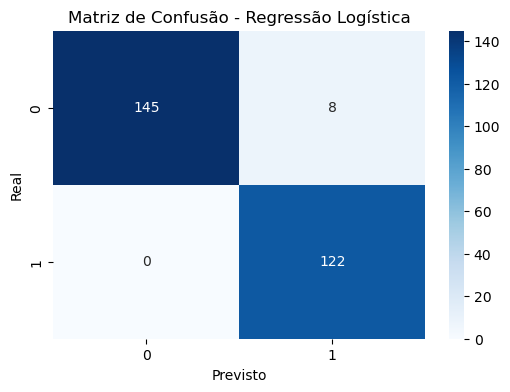

In [157]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("Resultado das Métricas: ")
acc_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Acurácia: {acc_lr:.4f}")
print(f"Precisão: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}")

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Regressão Logística')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

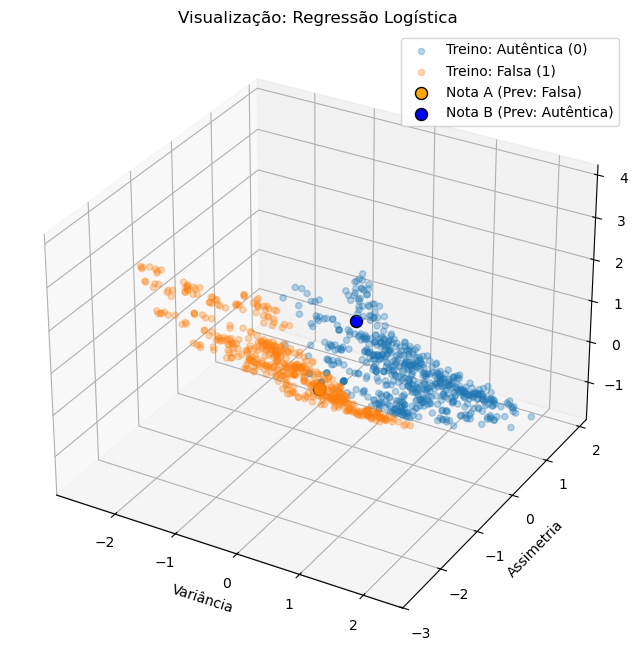

In [206]:
testar_e_visualizar(lr, "Regressão Logística", X_train, y_train, scaler)

**2. SVM (Support Vector Machine)**

In [144]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)

svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)

print("Resultado das Métricas: ")
acuracia_SVM = accuracy_score(y_test, y_pred)
precisao_SVM = precision_score(y_test, y_pred)
recall_SVM = recall_score(y_test, y_pred)
f1_SVM = f1_score(y_test, y_pred)

print(f"Acurácia: {acuracia_SVM:.4f}")
print(f"Precisão: {precisao_SVM:.4f}")
print(f"Recall: {recall_SVM:.4f}")
print(f"F1-Score: {f1_SVM:.4f}")

Resultado das Métricas: 
Acurácia: 0.9964
Precisão: 0.9919
Recall: 1.0000
F1-Score: 0.9959


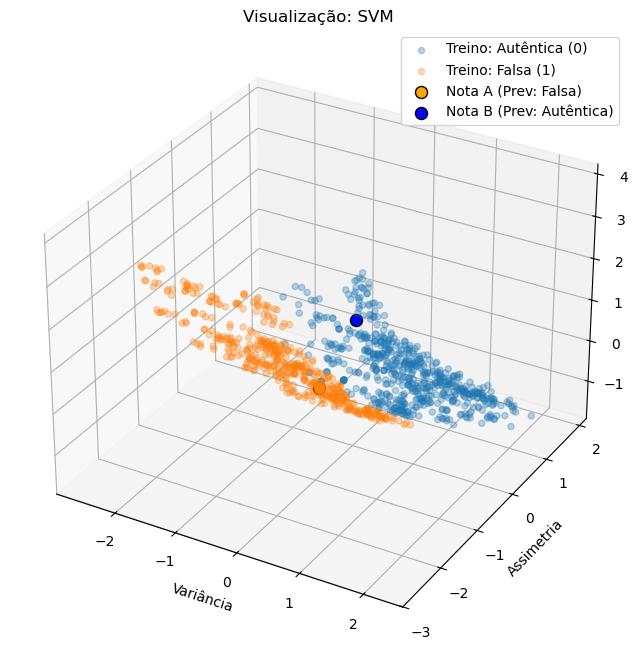

In [207]:
testar_e_visualizar(svm_classifier, "SVM", X_train, y_train, scaler)

**3. Árvore de Decisão**


--- Treinando Modelo 2: Árvore de Decisão ---
Acurácia: 0.9927
Precisão: 0.9839
Recall: 1.0000
F1-Score: 0.9919


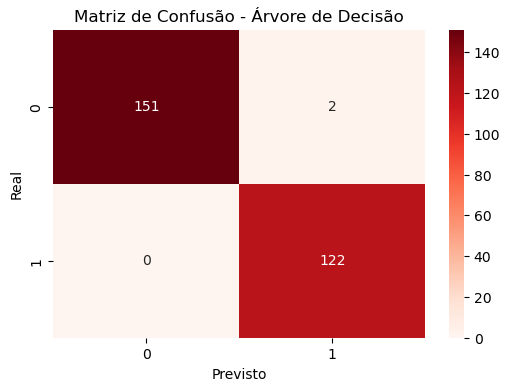

In [147]:
from sklearn.tree import DecisionTreeClassifier
# Lembre-se que as métricas (accuracy_score, etc.) já devem estar importadas

print("\n--- Treinando Modelo 2: Árvore de Decisão ---")

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

y_pred_dt = dt_classifier.predict(X_test)

# Avaliar com as métricas pedidas
acc_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

print(f"Acurácia: {acc_dt:.4f}")
print(f"Precisão: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1-Score: {f1_dt:.4f}")

# Gerar a Matriz de Confusão
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Reds')
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

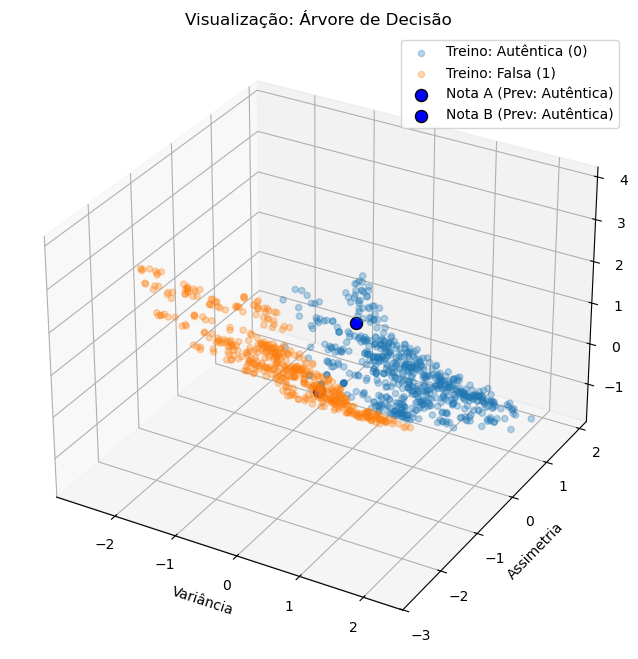

In [208]:
testar_e_visualizar(dt_classifier, "Árvore de Decisão", X_train, y_train, scaler)

**4. MLP (Multi-Layer Perceptron)**


--- Treinando Modelo 3: MLP (Rede Neural) ---
Acurácia: 0.9673
Precisão: 0.9313
Recall: 1.0000
F1-Score: 0.9644


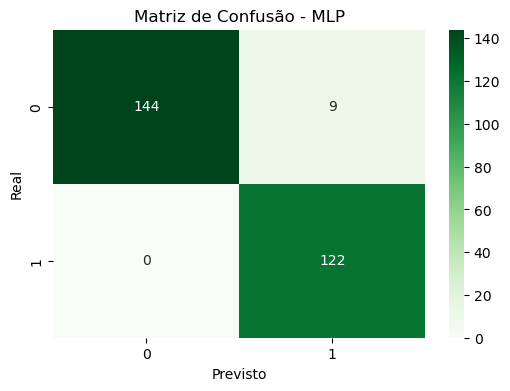

In [149]:
from sklearn.neural_network import MLPClassifier

print("\n--- Treinando Modelo 3: MLP (Rede Neural) ---")

# O MLP é sensível a hiperparâmetros. Usamos 'max_iter' e 'early_stopping' 
# para garantir que ele aprenda sem travar ou demorar demais.
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(100, 50), # Duas camadas, uma com 100 neurônios, outra com 50
    max_iter=500, 
    random_state=42, 
    early_stopping=True, # Para evitar overfitting e acelerar se não houver melhoria
    activation='relu' # Função de ativação padrão para redes neurais
)
mlp_classifier.fit(X_train, y_train)

y_pred_mlp = mlp_classifier.predict(X_test)

# Avaliar com as métricas pedidas
acc_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)

print(f"Acurácia: {acc_mlp:.4f}")
print(f"Precisão: {precision_mlp:.4f}")
print(f"Recall: {recall_mlp:.4f}")
print(f"F1-Score: {f1_mlp:.4f}")

# Gerar a Matriz de Confusão
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusão - MLP')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

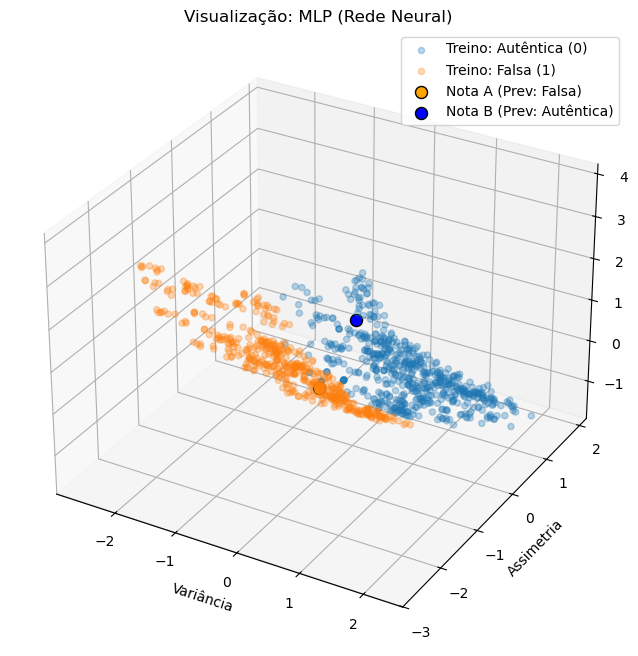

In [209]:
testar_e_visualizar(mlp_classifier, "MLP (Rede Neural)", X_train, y_train, scaler)

A Superioridade da Não-Linearidade no Dataset de Cédulas"

O Vencedor (SVM - 99,64%): O SVM com kernel RBF foi o campeão absoluto. Isso prova que a fronteira de decisão entre cédulas falsas e verdadeiras é complexa e curva. O SVM conseguiu projetar esses dados em uma dimensão superior e encontrar uma separação quase perfeita que uma linha reta não conseguiria.

O Vice (Árvore de Decisão - 99,27%): A Árvore também brilhou, confirmando que regras de decisão não-lineares ("se variância > X e curtose < Y") funcionam muito bem para este tipo de dado geométrico.

A Limitação Linear (Regressão Logística - 97,09%): A Regressão Logística teve um bom desempenho, mas atingiu um "teto de vidro". Por ser um modelo linear, ela não conseguiu capturar as nuances mais sutis da fronteira de decisão, errando onde os dados das duas classes se misturam na curva.

O Caso do MLP (96,73%): Curiosamente, a Rede Neural ficou ligeiramente atrás. Isso provavelmente se deve ao tamanho do dataset (pequeno para Deep Learning), o que pode ter levado a um leve overfitting ou dificuldade de convergência comparado à eficiência matemática do SVM em datasets menores.